# ACERCAMIENTO A LA ANALITICA DE DATOS PARA SEGMENTAR CLIENTES
## JUAN PABLO MONTOYA VALLEJO

¡Bienvenido a este notebook en el que se hace un acercamiento a la segmentación de clientes con el objetivo de encontrar grupos de clientes con gustos similares para poder crear campañas publicitarias personalizadas de productos que les atraigan.

En este notebook, Para ello, utilizaremos el método de clustering KMeans y la biblioteca de visualización Seaborn para ayudarnos a visualizar nuestros datos y entender mejor las relaciones entre ellos,explorar nuestros datos, identificar patrones y relaciones entre las variables.


In [2]:
import pandas_gbq
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import pickle
import h5py
warnings.filterwarnings("ignore")

In [3]:
with open('../../../app/SQL/Query_traer_clientes_simplificado.sql') as file:
    query=file.read()
data=pandas_gbq.read_gbq(query, project_id='customer-experience-384423',progress_bar_type=None)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250209 entries, 0 to 250208
Data columns (total 85 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id_cliente                         250209 non-null  Int64  
 1   promedio_compra                    250209 non-null  float64
 2   cantidad_compras                   250209 non-null  Int64  
 3   dropsize                           250209 non-null  float64
 4   contactable                        250209 non-null  Int64  
 5   compro_en_OUTLET                   250209 non-null  Int64  
 6   compro_en_ESTELAR                  250209 non-null  Int64  
 7   compro_en_MOVIES                   250209 non-null  Int64  
 8   compro_en_LITTLE_MIC               250209 non-null  Int64  
 9   compro_en_MOVIES_W                 250209 non-null  Int64  
 10  compro_en_OUTLET_MIC               250209 non-null  Int64  
 11  compro_en_EVENTOS                  2502

In [5]:
data.describe()

,id_cliente,promedio_compra,cantidad_compras,dropsize,contactable,compro_en_OUTLET,compro_en_ESTELAR,compro_en_MOVIES,compro_en_LITTLE_MIC,compro_en_MOVIES_W,...,compras_2019,compras_2020,compras_2021,recencia_1_3_meses,recencia_3_6_meses,recencia_6_9_meses,recencia_9_12_meses,recencia_1_o_mas_anos,gasto_sede_fisica,gasto_sede_online
count,250209.0,2.502090e+05,250209.0,250209.000000,250209.0,250209.0,250209.0,250209.0,250209.0,250209.0,...,1.600100e+04,4.145100e+04,1.229280e+05,130964.0,130964.0,130964.0,130964.0,130964.0,2.211740e+05,3.768100e+04
mean,125105.999996,8.160004e+04,8.379611,14670.555991,0.579476,0.0,0.0,0.0,0.846197,0.0,...,6.801734e+05,8.330051e+05,8.853949e+05,0.150591,0.203331,0.147338,0.065453,0.433287,9.326122e+05,1.303451e+06
std,72229.261096,6.437596e+04,29.776725,8610.990040,0.493644,0.0,0.0,0.0,0.360761,0.0,...,3.536511e+06,2.496913e+06,3.520044e+06,0.357651,0.402478,0.354444,0.247325,0.495531,3.920149e+06,4.980220e+06
min,1.0,-4.644237e+05,2.0,-175252.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.480640e+05,-1.470538e+06,-4.272698e+07,0.0,0.0,0.0,0.0,0.0,-4.272698e+07,-1.330546e+06
25%,62554.0,4.266033e+04,2.0,8611.333333,0.0,0.0,0.0,0.0,1.0,0.0,...,9.398400e+04,9.894700e+04,1.090760e+05,0.0,0.0,0.0,0.0,0.0,1.115840e+05,1.198000e+05
50%,125106.0,6.427800e+04,4.0,13504.250000,1.0,0.0,0.0,0.0,1.0,0.0,...,2.312620e+05,2.852080e+05,3.046380e+05,0.0,0.0,0.0,0.0,0.0,3.060930e+05,4.268240e+05
75%,187658.0,1.008320e+05,10.0,19156.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,6.049400e+05,8.075810e+05,8.066160e+05,0.0,0.0,0.0,0.0,1.0,8.158685e+05,1.278138e+06
max,250210.0,2.212655e+06,13606.0,245661.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,3.811134e+08,2.503512e+08,6.453132e+08,1.0,1.0,1.0,1.0,1.0,1.276596e+09,3.851241e+08


In [6]:
data.drop(columns=['contactable'],inplace=True)

In [7]:
len(data)

250209

In [8]:
len(data[data['promedio_compra']<0])

502

In [9]:
len(data[data['promedio_compra']<0])*100/len(data)

0.20063227142109197

In [10]:
len(data[data['promedio_compra']>1000000])

28

In [11]:
len(data[data['promedio_compra']>1000000])*100/len(data)

0.011190644621096764

<Axes: >

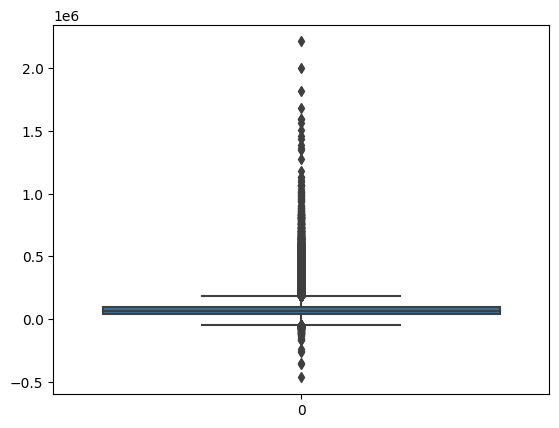

In [12]:
sns.boxplot(data['promedio_compra'])

<Axes: >

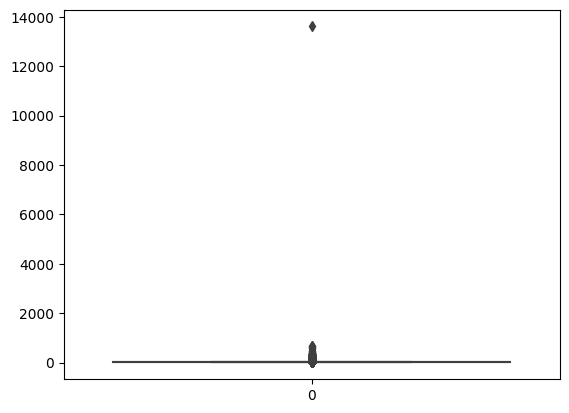

In [13]:
sns.boxplot(data['cantidad_compras'])

In [14]:
data_sin_outliers=data[(data['promedio_compra']<1000000) & (data['promedio_compra']>0)&(data['cantidad_compras']<500)]

<Axes: >

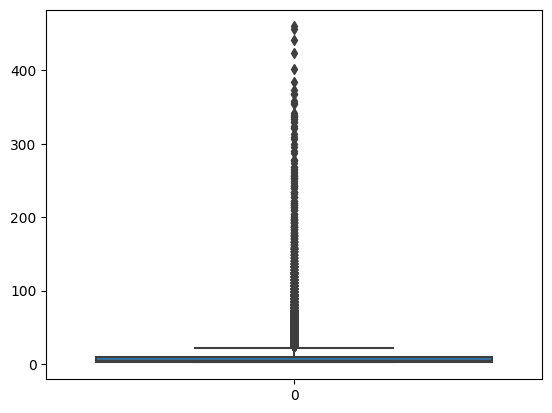

In [15]:
sns.boxplot(data_sin_outliers['cantidad_compras'])

<Axes: >

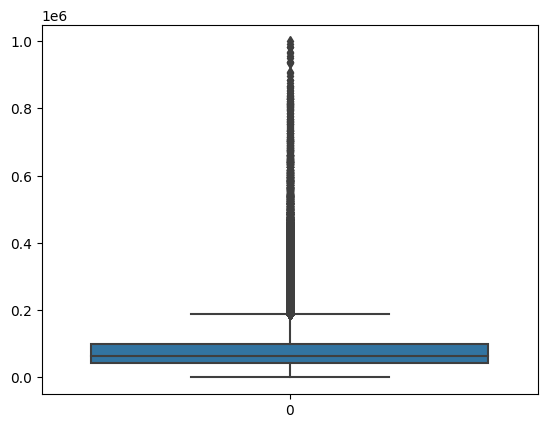

In [16]:
sns.boxplot(data_sin_outliers['promedio_compra'])

In [17]:
id_cliente=data_sin_outliers['id_cliente']
data_sin_outliers.drop(columns=['id_cliente'],inplace=True)

In [18]:
data_sin_outliers.fillna(0,inplace=True)

In [19]:
data_sin_outliers.describe()

,promedio_compra,cantidad_compras,dropsize,compro_en_OUTLET,compro_en_ESTELAR,compro_en_MOVIES,compro_en_LITTLE_MIC,compro_en_MOVIES_W,compro_en_OUTLET_MIC,compro_en_EVENTOS,...,compras_2019,compras_2020,compras_2021,recencia_1_3_meses,recencia_3_6_meses,recencia_6_9_meses,recencia_9_12_meses,recencia_1_o_mas_anos,gasto_sede_fisica,gasto_sede_online
count,2.492910e+05,249291.0,2.492910e+05,249291.0,249291.0,249291.0,249291.0,249291.0,249291.0,249291.0,...,2.492910e+05,2.492910e+05,2.492910e+05,249291.0,249291.0,249291.0,249291.0,249291.0,2.492910e+05,2.492910e+05
mean,8.179833e+04,8.310625,1.474207e+04,0.0,0.0,0.0,0.846637,0.0,0.0,0.0,...,4.141014e+04,1.366493e+05,4.254297e+05,0.078928,0.106658,0.077171,0.034205,0.226583,8.098486e+05,1.921821e+05
std,6.271728e+04,11.747464,8.503430e+03,0.0,0.0,0.0,0.360338,0.0,0.0,0.0,...,4.197894e+05,8.876203e+05,1.679972e+06,0.269627,0.308679,0.266863,0.181756,0.418621,2.301980e+06,1.573876e+06
min,4.547474e-13,2.0,4.092726e-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.790220e+05,-3.504160e+05,-1.518190e+06,0.0,0.0,0.0,0.0,0.0,-8.239200e+05,-1.928400e+05
25%,4.288200e+04,2.0,8.686888e+03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,7.645800e+04,0.000000e+00
50%,6.453800e+04,4.0,1.354725e+04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,2.435120e+05,0.000000e+00
75%,1.009032e+05,10.0,1.918150e+04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,2.968970e+05,0.0,0.0,0.0,0.0,0.0,7.053240e+05,0.000000e+00
max,9.992840e+05,460.0,2.456615e+05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,5.113336e+07,9.525155e+07,1.588375e+08,1.0,1.0,1.0,1.0,1.0,2.028885e+08,2.649560e+08


In [20]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_sin_outliers)
data_scaled = pd.DataFrame(data_scaled, columns=data_sin_outliers.columns)

In [21]:
data_scaled.describe()

,promedio_compra,cantidad_compras,dropsize,compro_en_OUTLET,compro_en_ESTELAR,compro_en_MOVIES,compro_en_LITTLE_MIC,compro_en_MOVIES_W,compro_en_OUTLET_MIC,compro_en_EVENTOS,...,compras_2019,compras_2020,compras_2021,recencia_1_3_meses,recencia_3_6_meses,recencia_6_9_meses,recencia_9_12_meses,recencia_1_o_mas_anos,gasto_sede_fisica,gasto_sede_online
count,249291.000000,249291.000000,249291.000000,249291.0,249291.0,249291.0,249291.000000,249291.0,249291.0,249291.0,...,249291.000000,249291.000000,249291.000000,249291.000000,249291.000000,249291.000000,249291.000000,249291.000000,249291.000000,249291.000000
mean,0.081857,0.013779,0.060010,0.0,0.0,0.0,0.846637,0.0,0.0,0.0,...,0.006233,0.005095,0.012121,0.078928,0.106658,0.077171,0.034205,0.226583,0.008020,0.001452
std,0.062762,0.025649,0.034614,0.0,0.0,0.0,0.360338,0.0,0.0,0.0,...,0.008165,0.009285,0.010477,0.269627,0.308679,0.266863,0.181756,0.418621,0.011300,0.005936
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.042913,0.000000,0.035361,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.005427,0.003665,0.009468,0.000000,0.000000,0.000000,0.000000,0.000000,0.004420,0.000727
50%,0.064584,0.004367,0.055146,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.005427,0.003665,0.009468,0.000000,0.000000,0.000000,0.000000,0.000000,0.005240,0.000727
75%,0.100975,0.017467,0.078081,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.005427,0.003665,0.011319,0.000000,0.000000,0.000000,0.000000,0.000000,0.007507,0.000727
max,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
filas_en_ceros=data_scaled.columns[data_scaled.sum()== 0].to_list()
data_scaled.drop(columns=filas_en_ceros,inplace=True)

In [23]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249291 entries, 0 to 249290
Data columns (total 50 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   promedio_compra                    249291 non-null  float64
 1   cantidad_compras                   249291 non-null  float64
 2   dropsize                           249291 non-null  float64
 3   compro_en_LITTLE_MIC               249291 non-null  float64
 4   compro_en_OUTLET_LITTLE_MIC        249291 non-null  float64
 5   dias_desde_ultima_compra_recencia  249291 non-null  float64
 6   PELUCHES                           249291 non-null  float64
 7   CALCETINES                         249291 non-null  float64
 8   PELUCHE                            249291 non-null  float64
 9   GAFAS                              249291 non-null  float64
 10  JUGUETERIA                         249291 non-null  float64
 11  SUECOS                             2492

<Axes: >

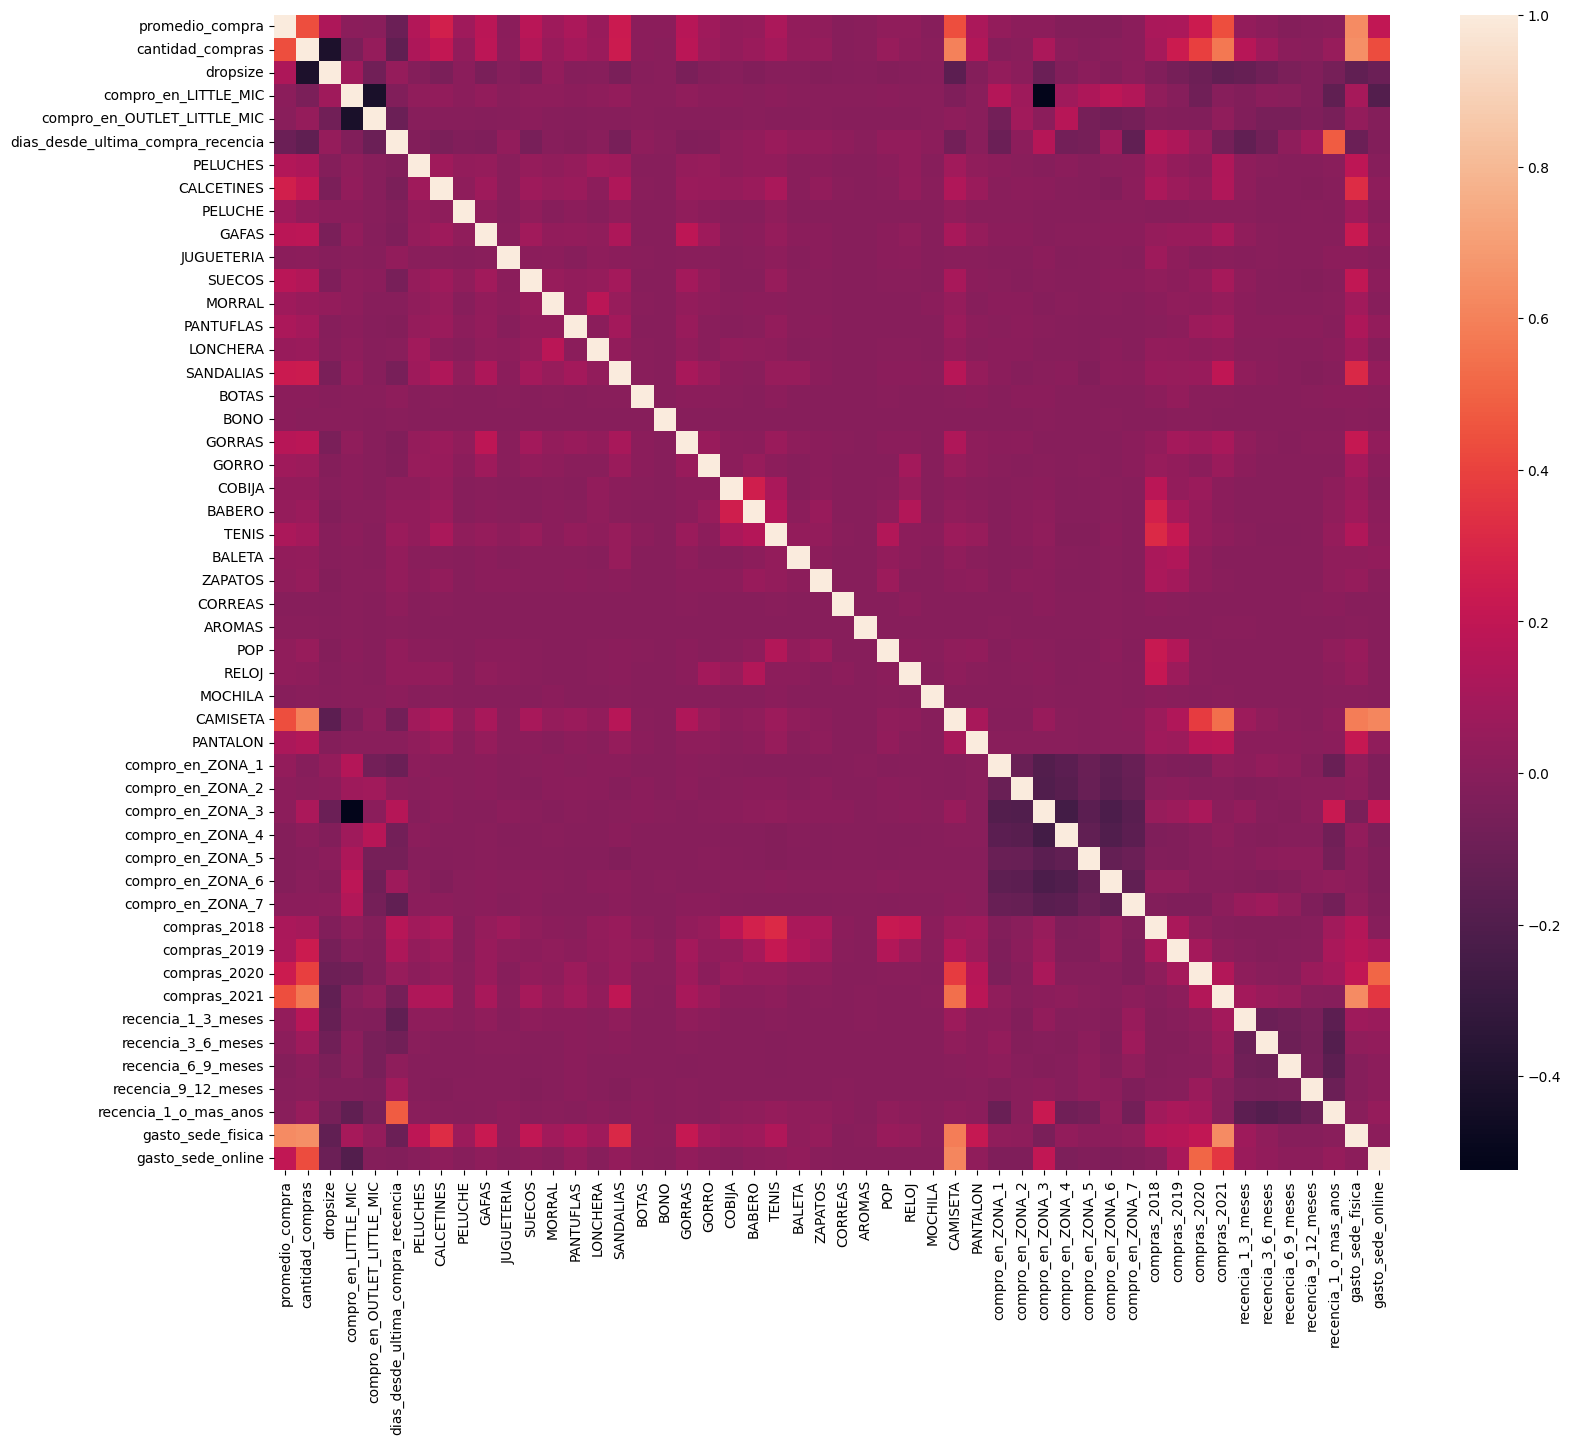

In [24]:
plt.figure(figsize=(18,15))
sns.heatmap(data=data_scaled.corr(), annot=False)

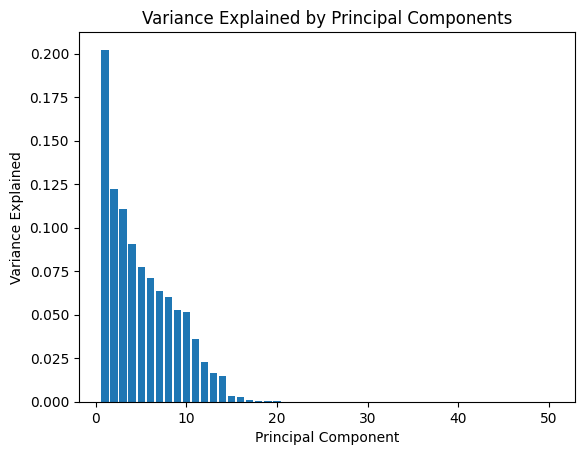

Explained Variance:
promedio_compra: 0.2022
cantidad_compras: 0.1224
dropsize: 0.1107
compro_en_LITTLE_MIC: 0.0906
compro_en_OUTLET_LITTLE_MIC: 0.0774
dias_desde_ultima_compra_recencia: 0.0710
PELUCHES: 0.0637
CALCETINES: 0.0604
PELUCHE: 0.0525
GAFAS: 0.0513
JUGUETERIA: 0.0358
SUECOS: 0.0228
MORRAL: 0.0165
PANTUFLAS: 0.0147
LONCHERA: 0.0032
SANDALIAS: 0.0027
BOTAS: 0.0008
BONO: 0.0002
GORRAS: 0.0002
GORRO: 0.0001
COBIJA: 0.0001
BABERO: 0.0001
TENIS: 0.0001
BALETA: 0.0001
ZAPATOS: 0.0001
CORREAS: 0.0001
AROMAS: 0.0000
POP: 0.0000
RELOJ: 0.0000
MOCHILA: 0.0000
CAMISETA: 0.0000
PANTALON: 0.0000
compro_en_ZONA_1: 0.0000
compro_en_ZONA_2: 0.0000
compro_en_ZONA_3: 0.0000
compro_en_ZONA_4: 0.0000
compro_en_ZONA_5: 0.0000
compro_en_ZONA_6: 0.0000
compro_en_ZONA_7: 0.0000
compras_2018: 0.0000
compras_2019: 0.0000
compras_2020: 0.0000
compras_2021: 0.0000
recencia_1_3_meses: 0.0000
recencia_3_6_meses: 0.0000
recencia_6_9_meses: 0.0000
recencia_9_12_meses: 0.0000
recencia_1_o_mas_anos: 0.0000
gas

In [25]:
columns = data_scaled.columns

pca = PCA()
pca.fit(data_scaled)

# Get the variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Plot the variance explained
plt.bar(range(1, len(variance_explained) + 1), variance_explained)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.show()

# Create a dictionary with column names and their explained variance
explained_variance_dict = dict(zip(columns, variance_explained))

print("Explained Variance:")
for column, explained_variance in explained_variance_dict.items():
    print(f"{column}: {explained_variance:.4f}")

In [26]:
pca = PCA(n_components=5)
pca.fit(data_scaled)
data_pca=pca.transform(data_scaled)

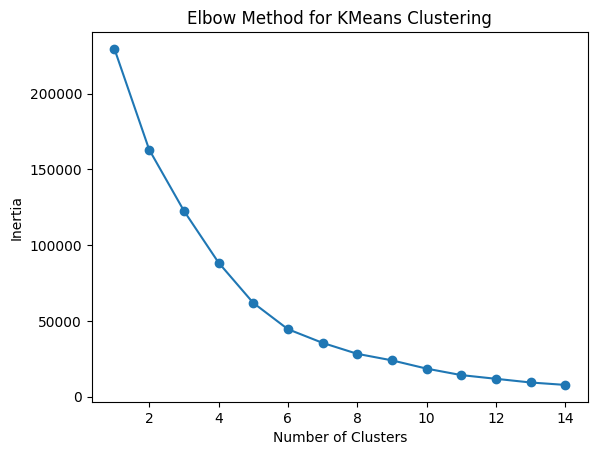

In [27]:
cluster_range = range(1, 15)  
inertias = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data_pca)
    inertias.append(kmeans.inertia_)


plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

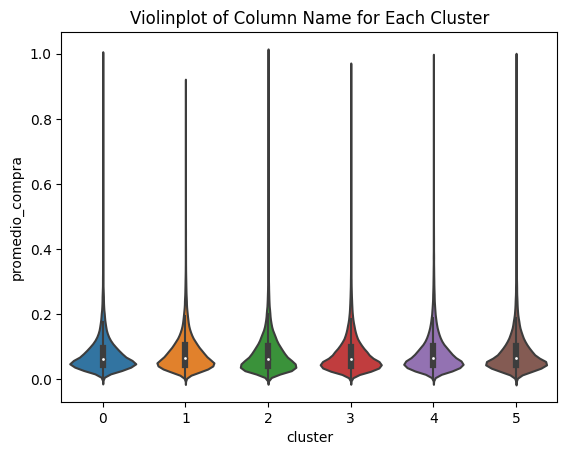

In [57]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(data_scaled)
labels = kmeans.labels_
data_scaled['cluster'] = labels
sns.violinplot(x='cluster', y='promedio_compra', data=data_scaled)
plt.title('Violinplot of Column Name for Each Cluster')
plt.show()

In [68]:
from sklearn.metrics import  silhouette_score
silhouette_avg = silhouette_score(data_scaled, labels)
silhouette_avg

0.4744396603016882

In [29]:
df_clusters = pd.DataFrame(kmeans.cluster_centers_, columns=data_scaled.columns)

In [62]:
df_clusters.round(4).T

,0,1,2,3,4,5
promedio_compra,0.0800,0.0791,0.0822,0.0833,0.0836,0.0835
cantidad_compras,0.0138,0.0136,0.0159,0.0114,0.0133,0.0137
dropsize,0.0588,0.0591,0.0569,0.0642,0.0611,0.0620
compro_en_LITTLE_MIC,0.9062,1.0000,0.4979,1.0000,0.9174,1.0000
compro_en_OUTLET_LITTLE_MIC,0.1160,0.0006,0.0480,0.0000,0.0893,0.0005
dias_desde_ultima_compra_recencia,0.1842,0.2478,0.2757,0.1666,0.2235,0.1346
PELUCHES,0.0431,0.0430,0.0428,0.0430,0.0430,0.0432
CALCETINES,0.0709,0.0703,0.0710,0.0708,0.0716,0.0716
PELUCHE,0.0001,0.0002,0.0001,0.0002,0.0002,0.0003
GAFAS,0.0492,0.0495,0.0488,0.0492,0.0494,0.0494


In [31]:

with open('../services/scaler-0.1.0.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [32]:
with h5py.File('../models/trained_model-0.1.0.h5', 'w') as file:
    file.create_dataset('cluster_centers_', data=kmeans.cluster_centers_)
    file.create_dataset('labels_', data=kmeans.labels_)
    file.create_dataset('inertia_', data=kmeans.inertia_)
    file.create_dataset('n_iter_', data=kmeans.n_iter_)

In [63]:
from google.cloud import storage
project_id='customer-experience-384423'
bucket_name = 'customer_experiende_machine_learning_models'

local_file_path_scaler = '../services/scaler-0.1.0.pkl'
remote_file_path_scaler = 'scaler-0.1.0.pkl'

local_file_path_kmeans_model = '../models/trained_model-0.1.0.h5'
remote_file_path_kmeans_model = 'trained_model-0.1.0.h5'

client = storage.Client(project=project_id)
bucket = client.get_bucket(bucket_name)

blob = bucket.blob(remote_file_path_scaler)
blob.upload_from_filename(local_file_path_scaler)
print(f'File {remote_file_path_scaler} uploaded to {bucket_name}.')

blob = bucket.blob(remote_file_path_kmeans_model)
blob.upload_from_filename(local_file_path_kmeans_model)
print(f'File {remote_file_path_kmeans_model} uploaded to {bucket_name}.')

File scaler-0.1.0.pkl uploaded to customer_experiende_machine_learning_models.
File trained_model-0.1.0.h5 uploaded to customer_experiende_machine_learning_models.


## Conclusiones
1. los clusters tienen una predileccion por agrupar a las personas de comportamiento similar por zonas 
2. en el cluster numero 2, que tiene en su mayoria personas de la zona 3 y algunos de las zonas 4,5 tienden mas a comprar por el canal ONLINE y estan un poco mas interesados en comprar relojes que los demas clusters
3. en el cluster numero 5, que tiene en su mayoria personas de la zona 2 y algunos de las zona 3 ,tienden a tener promedios de compra mas altos que los otros clusters y tienen una recencia mas alta que los demas, lo que indica que ellos gastan mas pero tambien se tardan mas en volver a comprar en las sucursales.
4. este modelo puede usarse para segmentar clientes de acuerdo a su comportamiento  con los servicios de la compañia y crear una base de datos de promociones en la que segun la asginacion de cluster a esa persona se le envie publicidad o campañas segun los productos mas comprados por cada cluster, por ejemplo:

    1. cluster 0: compran mas pantalones
    2. cluster 1: compran mas sandalias,suecos,gafas
    3. cluster 2: compran mas loncheras
    4. cluster 3: compran mas relojes,camiseta
    5. cluster 4: compran mas loncheras,gorras
    6. cluster 5: compran mas calcetines,sandalias,suecos,peluches


